Note: this notebook is meant to be a demo of some of the capabilities of **`oo-learning`** (https://github.com/shane-kercheval/oo-learning); it is not meant to show the best approach to exploring/cleaning/modeling this particular dataset. Also, with most graphs (e.g. correlations/box-plots/etc.) I will spend very little time commenting on the significance of any interesting or patterns. Again, the intent is to show a demo, not a guide to data analysis. 

# Set Up Environment

In [33]:
# !pip install oolearning --upgrade

In [34]:
from oolearning import *
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
width = 10
plt.rcParams['figure.figsize'] = [width, width/1.333]

# Import Data

`ExploreClassificationDataset` is a class that provides a lot of convenience for exploring a new (classification) dataset.

Below, the class is initialized from a csv file (but you can also initialize from an existing pandas DataFarme using the constructor (**`ExploreClassificationDataset(dataset, target_variable)`**).

Additionally, sometimes we have a numeric target (even though are target is logically categorical), that we would like to change in order to make the outcome more specific. In this example, we load in the **`titanic`** dataset (https://www.kaggle.com/c/titanic/data), and change the target variable (**`Survived`**) from **`1`'s** & **`0`'s**, to **`lived`**/**`died`**.

In [35]:
csv_file = '../data/titanic.csv'
target_variable = 'Survived'
target_mapping = {0: 'died', 1: 'lived'}  # so we can convert from numeric to categoric

explore = ExploreClassificationDataset.from_csv(csv_file_path=csv_file,
                                                target_variable=target_variable,
                                                map_numeric_target=target_mapping)

# Getting a General Understanding of the Data

In [36]:
explore.dataset.head()  # we can access the data directly by `.dataset`

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,died,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,lived,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,lived,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,lived,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,died,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The first thing that I noticed is **`Pclass`** is imported as numeric feature, but it might be better suited as categoric, so let's convert it. (Note below that **`Pclass`** will now show up under categoric values when we do **`.categoric_summary()`**.)

In [37]:
# Description of data says (https://www.kaggle.com/c/titanic/data):
# pclass: A proxy for socio-economic status (SES)
# 1st = Upper
# 2nd = Middle
# 3rd = Lower

# let's convert Pclass to categoric variable
explore.set_as_categoric(feature='Pclass', mapping={1: 'Upper', 2: 'Middle', 3: 'Lower'})

Let's explore the numeric columns.

In [38]:
explore.numeric_summary()

,count,nulls,perc_nulls,num_zeros,perc_zeros,mean,st_dev,coef of var,skewness,kurtosis,min,10%,25%,50%,75%,90%,max
PassengerId,891,0,0.000,0,0.000,446.000,257.354,0.577,0.000,-1.200,1.00,90.00,223.500,446.000,668.5,802.000,891.000
Age,714,177,0.199,0,0.000,29.699,14.526,0.489,0.389,0.178,0.42,14.00,20.125,28.000,38.0,50.000,80.000
SibSp,891,0,0.000,608,0.682,0.523,1.103,2.108,3.695,17.880,0.00,0.00,0.000,0.000,1.0,1.000,8.000
Parch,891,0,0.000,678,0.761,0.382,0.806,2.112,2.749,9.778,0.00,0.00,0.000,0.000,0.0,2.000,6.000
Fare,891,0,0.000,15,0.017,32.204,49.693,1.543,4.787,33.398,0.00,7.55,7.910,14.454,31.0,77.958,512.329


A couple of things we might note, for example:

    A) `Age` has missing values.
    B) `Fare` has `15` zeros, which we might assume is equivalent to a missing/null value. (Tickets probably weren't free.)
    C) `PassengerId` will not be helpful.

Now let's explore the categoric columns.

In [39]:
explore.categoric_summary()

,count,nulls,perc_nulls,top,unique,perc_unique
Pclass,891,0,0.000,Lower,3,0.003
Name,891,0,0.000,"van Melkebeke, Mr. Philemon",891,1.000
Sex,891,0,0.000,male,2,0.002
Ticket,891,0,0.000,CA. 2343,681,0.764
Cabin,204,687,0.771,B96 B98,147,0.721
Embarked,889,2,0.002,S,3,0.003
Survived,891,0,0.000,died,2,0.002


For these columns, I might note, for example, that `Name`, `Ticket`, and `Cabin` all have a very high number of unique values (`Cabin` also have a high number of null values). This obviously make sense, but also means we might not want to use these columns.

_(Note: in https://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html, the author describes how he cleverly extracts the title associated with the name, where applicable. That is a great idea, but outside the scope of this demo.)_

In [40]:
explore.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])  # drop/remove specific columns

In [41]:
explore.dataset.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,died,Lower,male,22.0,1,0,7.2500,S
1,lived,Upper,female,38.0,1,0,71.2833,C
2,lived,Lower,female,26.0,0,0,7.9250,S
3,lived,Upper,female,35.0,1,0,53.1000,S
4,died,Lower,male,35.0,0,0,8.0500,S


# Diving In

## Numeric Features

Let's dive in a little more into the characteristics of our numeric features.

### Correlations

A good place to start is with an overall idea of how correlated our numeric features are.

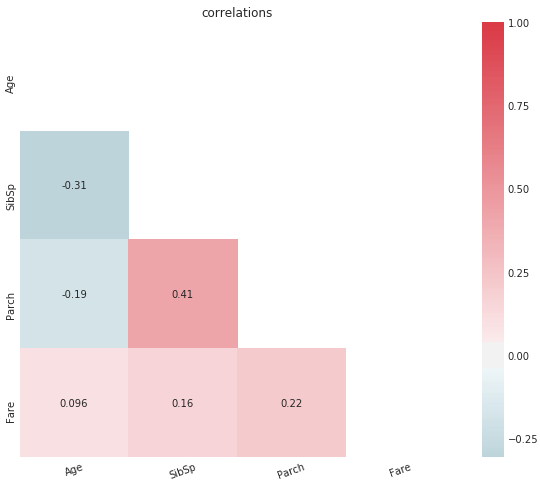

In [42]:
explore.plot_correlation_heatmap()

### Features

Now let's take a look at each numeric feature, by itself, as well as how it relates to our target variable.

#### Age

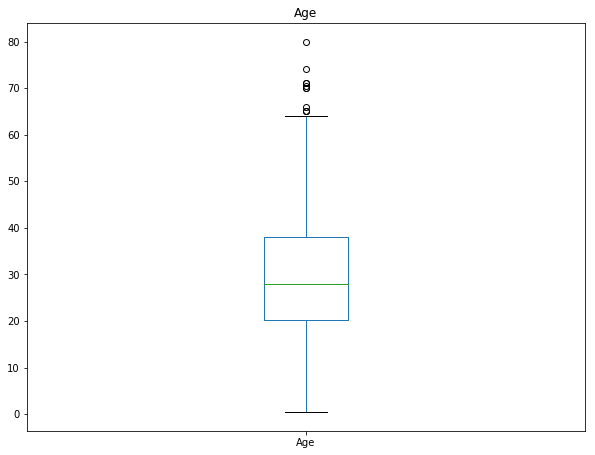

In [43]:
explore.plot_boxplot(numeric_feature='Age')

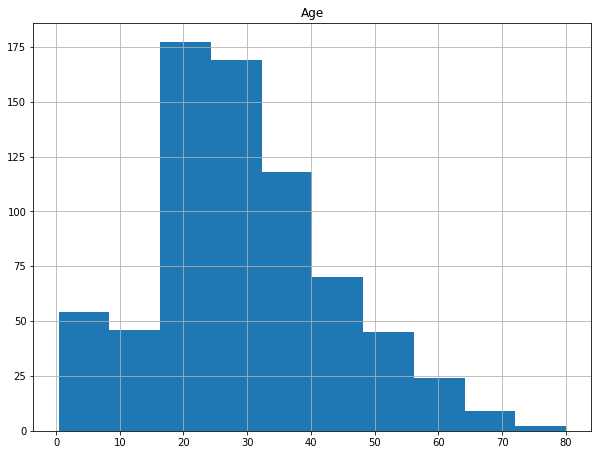

In [44]:
explore.plot_histogram(numeric_feature='Age')

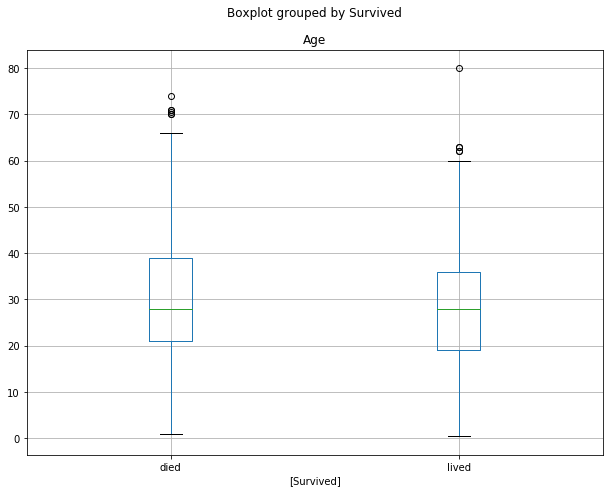

In [45]:
explore.plot_against_target('Age')

#### SibSp

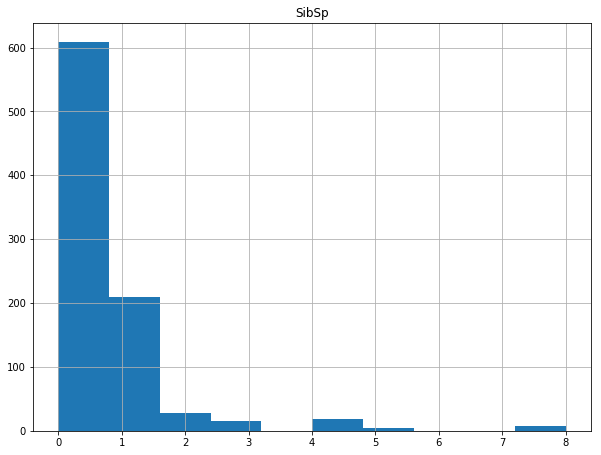

In [46]:
explore.plot_histogram(numeric_feature='SibSp')

#### Parch

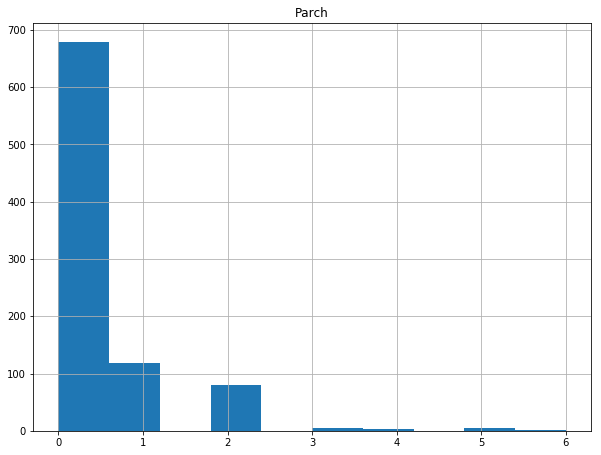

In [47]:
explore.plot_histogram(numeric_feature='Parch')

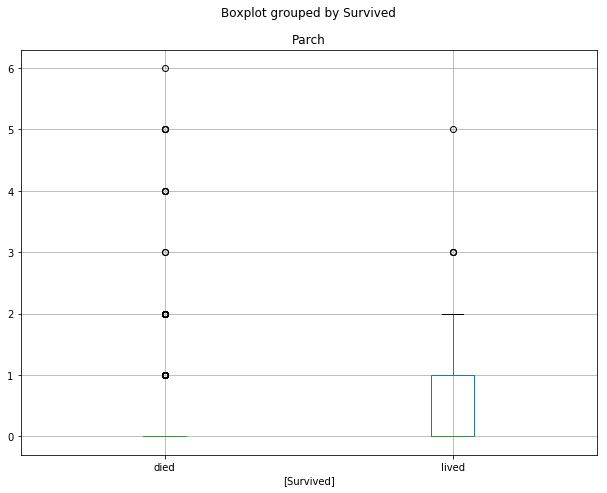

In [48]:
explore.plot_against_target('Parch')

Above, we saw there was moderate correlation of **`Parch`** and  **`SibSp`**, let's look at a scatter plot to see if it shows anything useful.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11139c320>,
      dtype=object)

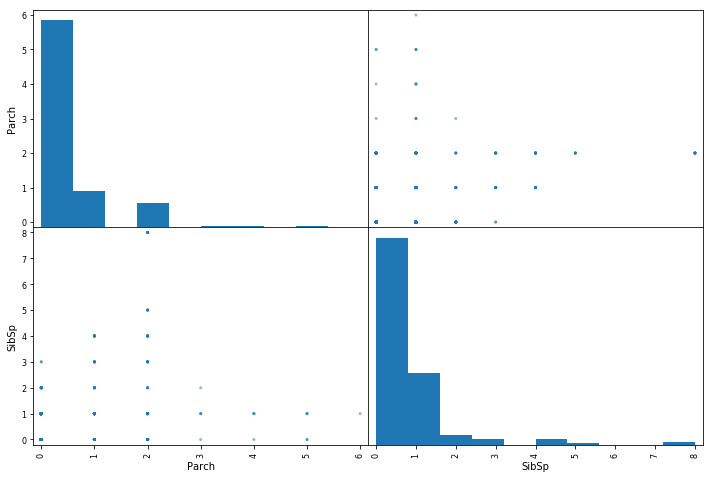

In [49]:
explore.plot_scatterplot_numerics(numeric_columns=['Parch', 'SibSp'])

#### Fare

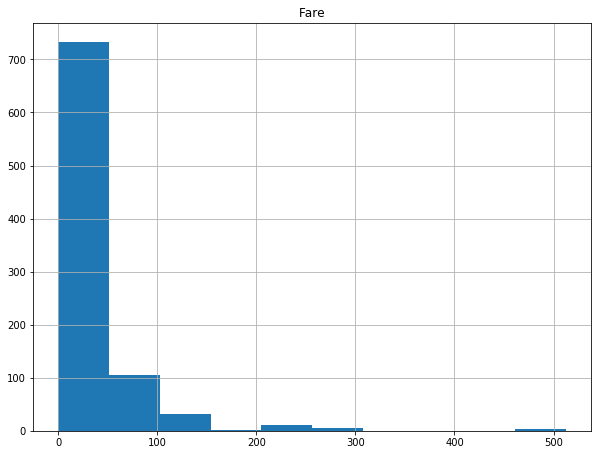

In [50]:
explore.plot_histogram(numeric_feature='Fare')

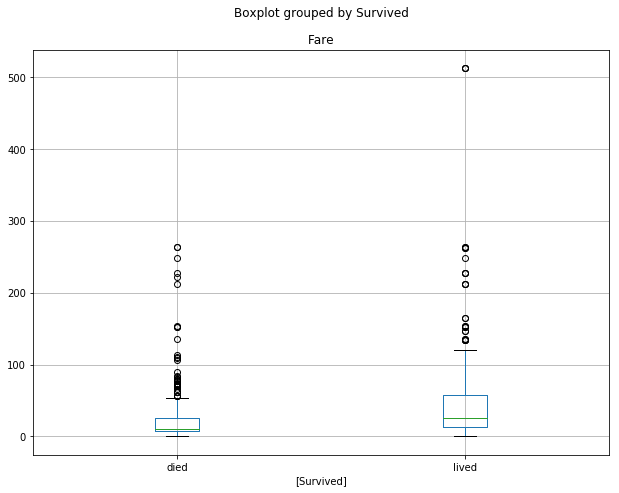

In [51]:
explore.plot_against_target('Fare')

## Categoric Features

Let's dive in a little more into the characteristics of our categoric features.

#### Pclass

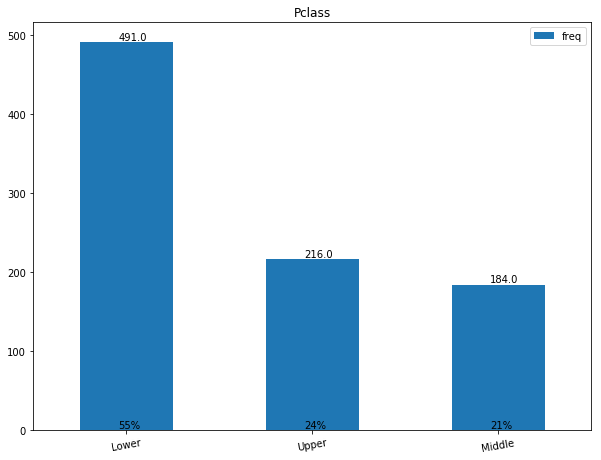

In [52]:
explore.plot_unique_values('Pclass')

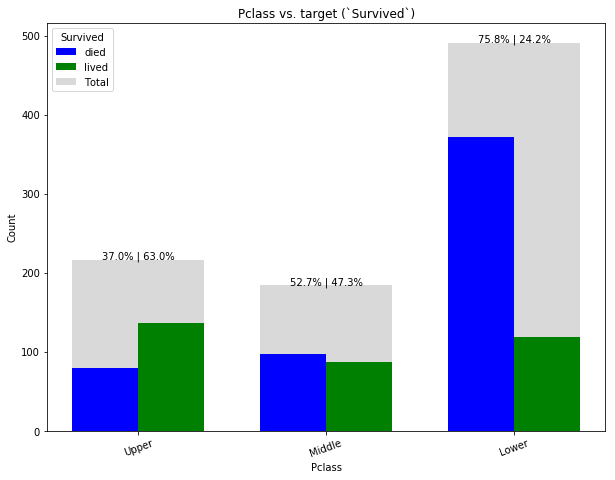

In [53]:
explore.plot_against_target(feature='Pclass')

#### Sex

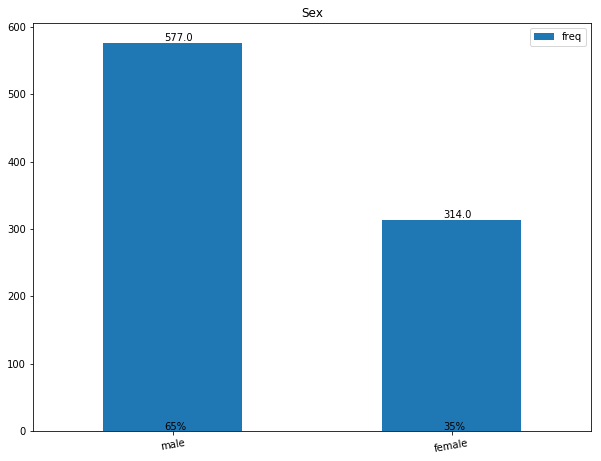

In [54]:
explore.plot_unique_values('Sex')

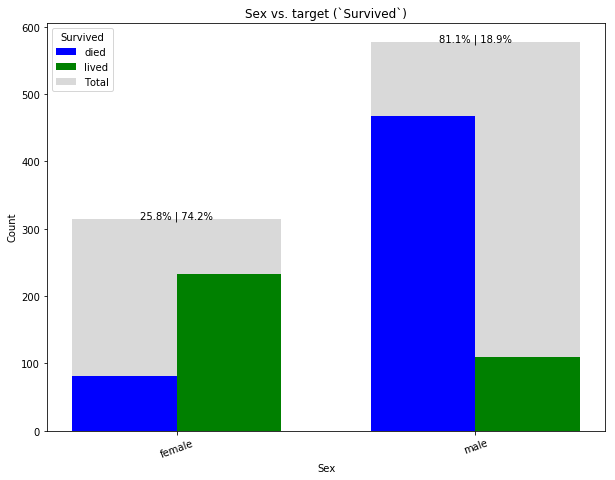

In [55]:
explore.plot_against_target('Sex')

#### Embarked

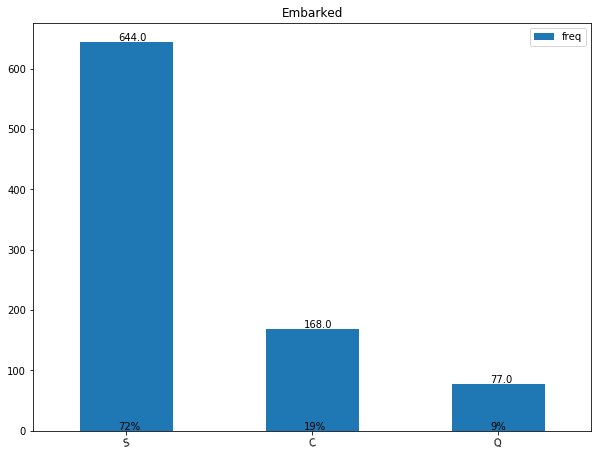

In [56]:
explore.plot_unique_values('Embarked')

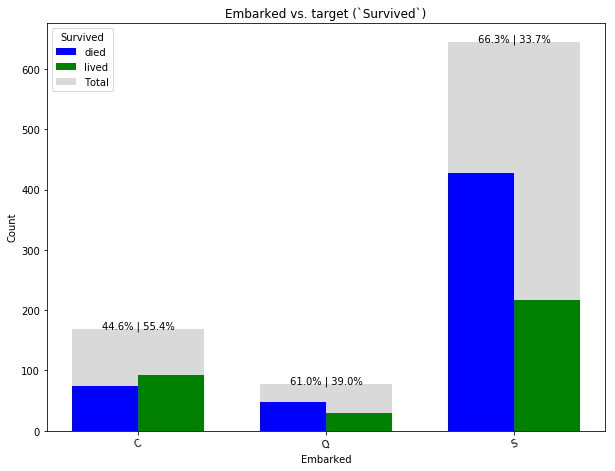

In [57]:
explore.plot_against_target('Embarked')